In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/k-means-project-tutorial/main/housing.csv"
df = pd.read_csv(url)

features = ["Latitude", "Longitude", "MedInc"]
X = df[features].copy()

# Split 80/20 para evitar leakage
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [3]:
# kmeans con k=6 (con escalado)
k = 6
kmeans_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=k, n_init=20, random_state=42))
])

kmeans_pipe.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=6, n_init=20, random_state=42))])

In [4]:
# Asignamos cluster a train y test
train_clusters = kmeans_pipe.predict(X_train)
test_clusters  = kmeans_pipe.predict(X_test)

X_train_k = X_train.copy()
X_test_k  = X_test.copy()
X_train_k["cluster"] = train_clusters
X_test_k["cluster"]  = test_clusters

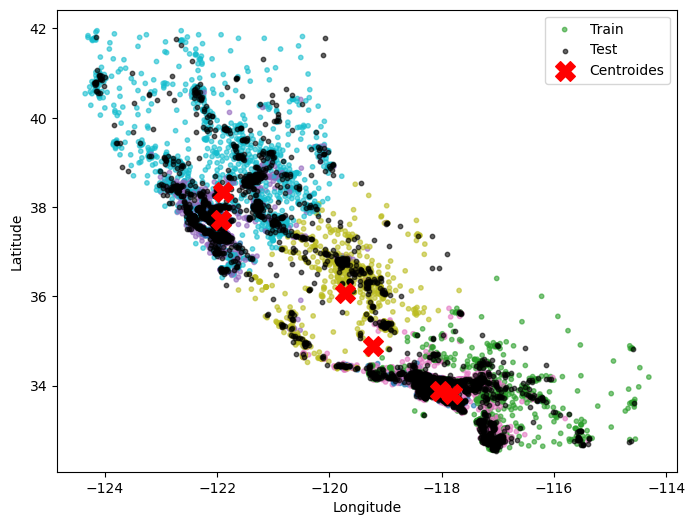

In [5]:
# gráfica: Train (coloreado por cluster) + Test (en negro) + Centroides
scaler = kmeans_pipe.named_steps["scaler"]
kmeans = kmeans_pipe.named_steps["kmeans"]

centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_train_k["Longitude"], X_train_k["Latitude"],
            c=X_train_k["cluster"], cmap="tab10", s=10, alpha=0.6, label="Train")
plt.scatter(X_test_k["Longitude"], X_test_k["Latitude"],
            c="black", s=10, alpha=0.6, label="Test")
plt.scatter(centroids[:, 1], centroids[:, 0],  # Longitud, Latitud
            c="red", marker="X", s=200, label="Centroides")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [9]:
# clasificador supervisado para imitar kmeans
# tenemos etiquetas artificiales (clusters) creadas por el kmeas
# queremos un modelo supervisado que pueda aprender a asignar esos clusters sin necesidad de volver a ejecutar el kmeans
# kmeans -> genera etiquetas
# randomforest -> predice esas etiquetas para datos nuevos.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_train = X_train_k["cluster"].to_numpy()
y_test  = X_test_k["cluster"].to_numpy()

clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [7]:
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))

Accuracy: 0.9954
Matriz de confusión:
 [[ 110    0    0    2    0    0]
 [   0 1373    0    2    0    0]
 [   0    0  512    0    0    3]
 [   0    2    0  826    0    0]
 [   0    0    0    1  333    3]
 [   0    0    5    0    1  955]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0     1.0000    0.9821    0.9910       112
           1     0.9985    0.9985    0.9985      1375
           2     0.9903    0.9942    0.9922       515
           3     0.9940    0.9976    0.9958       828
           4     0.9970    0.9881    0.9925       337
           5     0.9938    0.9938    0.9938       961

    accuracy                         0.9954      4128
   macro avg     0.9956    0.9924    0.9940      4128
weighted avg     0.9954    0.9954    0.9954      4128



In [ ]:
import joblib

joblib.dump(kmeans_pipe, "kmeans_california.pkl")
joblib.dump(clf,         "cluster_classifier.pkl")
print("\nGuardados")
print("- /kmeans_california.pkl")
print("- /cluster_classifier.pkl")


Guardados
- /kmeans_california.pkl
- /cluster_classifier.pkl
